In [1]:
#Necessary Imports
import os
#os.system("pip freeze > requirements.txt")
#os.system("pip install -r requirements.txt")
os.system("pip install umap-learn")
os.system("pip install mplhep")
os.system("pip install psycopg2-binary --user")

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
from io import BytesIO
from PIL import Image
import base64
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
import dask.array as da

import tensorflow as tf
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
from umap.parametric_umap import ParametricUMAP as PUMAP
import sys
os.system("pip show psycopg2-binary")
sys.path.append("/home/jovyan/.local/lib/python3.11/site-packages")

import psycopg2
import subprocess

2024-12-19 22:25:16.878655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Name: psycopg2-binary
Version: 2.9.10
Summary: psycopg2 - Python-PostgreSQL Database Adapter
Home-page: https://psycopg.org/
Author: Federico Di Gregorio
Author-email: fog@initd.org
License: LGPL with exceptions
Location: /home/jovyan/.local/lib/python3.11/site-packages
Requires: 
Required-by: 


In [2]:
# Connect to the database
conn = psycopg2.connect(host="adc-2021.c7skue2e0u6i.us-east-1.rds.amazonaws.com",
                        user="postgres",
                        password="UM#37tz;80",
                        port="5432")
cur = conn.cursor()

# Set the schema to be used
cur.execute("SET search_path TO l1anomaly")
# random_background_indices = np.random.choice(2000000, size=2000000, replace=False)
# random_signal_indices = np.random.choice(600000, size=600000, replace=False)
random_background_indices = np.random.choice(1000, size=1000, replace=False)
random_signal_indices = np.random.choice(1000, size=1000, replace=False)
# Convert numpy arrays to comma-separated strings
random_background_indices_str = ', '.join(map(str, random_background_indices))
random_signal_indices_str = ', '.join(map(str, random_signal_indices))

cur.execute(f"SELECT * FROM background_for_training WHERE idbackground_for_training IN ({random_background_indices_str})")
background_data = cur.fetchall()

cur.execute(f"SELECT * FROM hToTauTau_13TeV_PU20_filtered WHERE idhToTauTau_13TeV_PU20_filtered IN ({random_signal_indices_str})")
signal_data = cur.fetchall()

background_data = np.array(background_data)
signal_data = np.array(signal_data)

#Let's try getting the data in with batching

# Function to query in batches and collect data
# def fetch_data_in_batches(cursor, table_name, id_column, id_list, batch_size=10000):
#     data = []
#     for i in range(0, len(id_list), batch_size):
#         # Extract the current batch of IDs
#         batch = id_list[i:i + batch_size]
#         batch_str = ', '.join(map(str, batch))
        
#         # Execute the query for the current batch
#         query = f"SELECT * FROM {table_name} WHERE {id_column} IN ({batch_str})"
#         print("Query: " + str(i))
#         cursor.execute(query)
        
#         # Fetch and extend the data list
#         data.extend(cursor.fetchall())
#     return np.array(data)

# Connect to the database
# conn = psycopg2.connect(host="adc-2021.c7skue2e0u6i.us-east-1.rds.amazonaws.com",
#                         user="postgres",
#                         password="UM#37tz;80",
#                         port="5432")
# cur = conn.cursor()

# Set the schema to be used
# cur.execute("SET search_path TO l1anomaly")

# Generate random indices for background and signal
# random_background_indices = np.random.choice(13000000, size=3000000, replace=False)
# random_signal_indices = np.random.choice(690000, size=690000, replace=False)

# Fetch background data in batches
# background_data = fetch_data_in_batches(
#     cur,
#     table_name="background_for_training",
#     id_column="idbackground_for_training",
#     id_list=random_background_indices,
#     batch_size=500000  # Adjust batch size as needed
# )

# # Fetch signal data in batches
# signal_data = fetch_data_in_batches(
#     cur,
#     table_name="hToTauTau_13TeV_PU20_filtered",
#     id_column="idhToTauTau_13TeV_PU20_filtered",
#     id_list=random_signal_indices,
#     batch_size=100000
# )

# Signal label
signal_label = "$h^{{0}} \\to \\tau\\tau$"

# Close the database connection
conn.close()

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def mse_loss(inputs, outputs):
    #Mean distance squared between input and output tensors
    return tf.math.reduce_mean((inputs - outputs) ** 2, axis=-1)

# def make_mse_per_sample(inputs, outputs):
#     outputs = tf.cast(outputs, dtype=inputs.dtype)  # make same type

#     inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
#     outputs = tf.reshape(outputs, [-1, (nmet + nele + nmu + njet), nfeat])

#     # extract pt
#     outputs_pt = outputs[:, :, 0]

#     # trick with phi (rescaled tanh activation function)
#     outputs_phi = phi_max * tf.math.tanh(outputs[:, :, 2])

#     # trick with eta (rescaled tanh activation function)
#     outputs_eta_met = outputs[:, 0:1, 1]
#     outputs_eta_ele = ele_eta_max * tf.math.tanh(
#         outputs[:, ele_off : ele_off + nele, 1]
#     )
#     outputs_eta_mu = mu_eta_max * tf.math.tanh(outputs[:, mu_off : mu_off + nmu, 1])
#     outputs_eta_jet = jet_eta_max * tf.math.tanh(
#         outputs[:, jet_off : jet_off + njet, 1]
#     )
#     outputs_eta = tf.concat(
#         [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
#     )

#     # use both tricks
#     outputs = tf.stack([outputs_pt, outputs_eta, outputs_phi], axis=-1)

#     # mask zero features
#     mask = tf.math.not_equal(inputs, 0)
#     mask = tf.cast(mask, dtype=outputs.dtype)
#     outputs = mask * outputs

#     loss = mse_loss(
#         tf.reshape(inputs, [-1, (1 + nele + nmu + njet) * nfeat]),
#         tf.reshape(outputs, [-1, (1 + nele + nmu + njet) * nfeat]),
#     )
#     return loss

def make_mse_per_sample(inputs, outputs):
    outputs = tf.cast(outputs, dtype=inputs.dtype)  # make inputs and outputs same type

    #1+4+4+10 = 19 with 3 features of pT, eta, phi which are transverse momentum, pseduorapidity, azimuthal angle
    # as in Main AE paper
    inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
    outputs = tf.reshape(outputs, [-1, (nmet + nele + nmu + njet), nfeat])

    # extract pt
    outputs_pt = outputs[:, :, 0]
    
    # extract class
    outputs_class = outputs[:, :, 3]

    # trick with phi (rescaled tanh activation function) - pi times tanh of azimuthal angle
    outputs_phi = phi_max * tf.math.tanh(outputs[:, :, 2])

    #Extracts missing transverse energy pseudorapidity outputs
    outputs_eta_met = outputs[:, 0:1, 1]

    # trick with eta (rescaled tanh activation function) - max electron pseudorapidity times tanh of pseudorapidity
    outputs_eta_ele = ele_eta_max * tf.math.tanh(
        outputs[:, ele_off : ele_off + nele, 1]
    )

    #Treatment of muon pseudorapidity analogous to that of electron
    outputs_eta_mu = mu_eta_max * tf.math.tanh(outputs[:, mu_off : mu_off + nmu, 1])

    #Treatment of jet pseudorapidity analogous to that of electrons and muons
    outputs_eta_jet = jet_eta_max * tf.math.tanh(
        outputs[:, jet_off : jet_off + njet, 1]
    )

    #Output psuedorapidity is triple with missing transverse eneergy, electron, muon, jet
    outputs_eta = tf.concat(
        [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
    )

    # use both tricks - stacks into standard triple - transvere momenta, pseudorapidity, azimuthal angle
    outputs = tf.stack([outputs_pt, outputs_eta, outputs_phi, outputs_class], axis=-1)

    # mask zero features - Zero Padding after output formation
    mask = tf.math.not_equal(inputs, 0)
    mask = tf.cast(mask, dtype=outputs.dtype)
    outputs = mask * outputs

    #Apply previously defined MSE_loss function 1 - corresponding to nmet
    loss = mse_loss(
        tf.reshape(inputs, [-1, (nmet + nele + nmu + njet) * nfeat]),
        tf.reshape(outputs, [-1, (nmet + nele + nmu + njet) * nfeat]),
    )
    return loss


def make_mse(inputs, outputs):
    loss = make_mse_per_sample(inputs, outputs)

    loss = tf.math.reduce_mean(loss, axis=0)  # average over batch
    loss = tf.cast(loss, dtype=inputs.dtype)

    return loss


def scale_pt(X, pt_scaler=None):
    pt = X[:, 0::nfeat]
    if pt_scaler is None:
        pt_scaler = StandardScaler()
        pt_scaled = pt_scaler.fit_transform(pt)
    else:
        pt_scaled = pt_scaler.transform(pt)
    X_scaled = np.copy(X)
    X_scaled[:, 0::nfeat] = np.multiply(pt_scaled, pt != 0)
    return X_scaled, pt_scaler

In [4]:
#Fundamental Constants

nfeat = 4
nmet = 1
nele = 4
nmu = 4
njet = 10
ele_off = 1
mu_off = nmet + nele
jet_off = nmet + nele + nmu
phi_max = np.pi
ele_eta_max = 3.0
mu_eta_max = 2.1
jet_eta_max = 4.0

[]

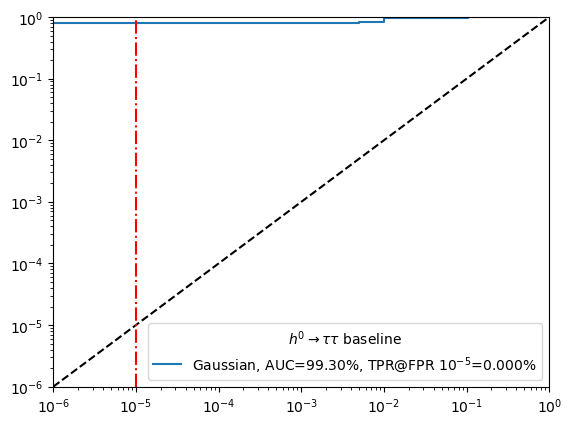

In [5]:
#Start with Gaussian
# background_data_reduced, extraneous = train_test_split(background_data, test_size = 0.5)


X_train_val, X_test = train_test_split(background_data.reshape(background_data.shape[0], -1), test_size=0.2, shuffle=True)
X_train, X_val = train_test_split(X_train_val, test_size=0.2, shuffle=True)
scaler = StandardScaler()
scaler.fit(X_train)
signal_data = signal_data.reshape(signal_data.shape[0], -1)
merged_data = np.concatenate([X_test, signal_data], axis=0)
merged_labels = np.concatenate([np.zeros(X_test.shape[0]), np.ones(signal_data.shape[0])], axis=0)
merged_data_trans = scaler.transform(merged_data)
merged_loss = np.sum(merged_data_trans ** 2, axis=-1)
fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
tpr_1em5 = find_nearest(fpr, 1e-5)

fpr_gaussian = fpr
tpr_gaussian = tpr
tpr_1em5_gaussian = tpr_1em5
auc_gaussian = auc
plt.plot(fpr_gaussian, tpr_gaussian, label=f"Gaussian, AUC={auc(fpr_gaussian, tpr_gaussian)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_gaussian[tpr_1em5_gaussian]*100:.3f}%")
plt.legend(title = str(signal_label) +" baseline")
plt.plot([1e-6, 1], [1e-6, 1], 'k--')
plt.plot([1e-5, 1e-5], [1e-6, 1], 'r-.')
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

In [6]:
#Continue with PUMAP
X_train_scaled, pt_scaler = scale_pt(X_train)

X_test_scaled, _ = scale_pt(X_test, pt_scaler)

In [7]:
def get_loss_pumap(X_scaled,inv_transform_data):
    #Extract loss from model predictions using make_mse_per_sample function analyzed above
    return np.array(make_mse_per_sample(X_scaled, inv_transform_data))

In [8]:
def get_loss_pca(X_scaled,inv_transform_data):
    #Extract loss from model predictions using make_mse_per_sample function analyzed above
    return np.array(make_mse_per_sample(X_scaled, inv_transform_data))

In [9]:
# Create a Dask array from the full dataset
# X_train_scaled_dask = da.from_array(X_train_scaled, chunks=(1_000_000, X_train_scaled.shape[1]))

In [10]:
# Define the model
model = PUMAP(low_memory=True)

In [11]:
trainEmbedding = model.fit_transform(X_train_scaled)
# We fit the entire dataset at once (but it’s done in chunks internally)
# This will avoid multiple fit calls but still scale efficiently
# trainEmbedding = model.fit_transform(X_train_scaled_dask.compute())
# inv_transform_training_data = model.inverse_transform(trainEmbedding)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2401
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2109
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2055
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2031
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2008
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1996
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1988
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1988
Epoch 9/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1981
Epoch 10/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1986


In [12]:
# Inverse transform in batches (to avoid memory overload)
# batch_size = 1_000_000  # Adjust based on available memory
# num_batches = len(trainEmbedding) // batch_size + 1

# inv_transform_training_data = []

# for i in range(num_batches):
#     start = i * batch_size
#     end = min((i + 1) * batch_size, len(trainEmbedding))
#     print(f"Inverse transforming batch {i + 1}/{num_batches}")
#     inv_batch = model.inverse_transform(trainEmbedding[start:end])
#     inv_transform_training_data.append(inv_batch)

# # Combine batches into a single array
# inv_transform_training_data = np.vstack(inv_transform_training_data)
inv_transform_training_data = model.inverse_transform(trainEmbedding)

In [13]:
print((X_train_scaled).shape)

(639, 77)


In [14]:
background_loss = get_loss_pumap(X_train_scaled[:, 1:], inv_transform_training_data[:, 1:])

plt.figure()

signal_data = signal_data.reshape(signal_data.shape[0], -1)
signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
merged_labels = np.concatenate(
    [np.zeros(X_train.shape[0]), np.ones(signal_data.shape[0])], axis=0
)

print("Starting PUMAP signal embedding: " + signal_label)
inv_transform_signal_data = model.inverse_transform(model.transform(signal_data_scaled))

signal_loss = get_loss_pumap(signal_data_scaled[:, 1:], inv_transform_signal_data[:, 1:])
merged_loss = np.concatenate([background_loss, signal_loss], axis=0)

print("Successful PUMAP signal embedding, inverse transform, and loss computations: " + signal_label)

fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
tpr_1em5 = find_nearest(fpr, 1e-5)

fpr_pumap = fpr
tpr_pumap = tpr
tpr_1em5_pumap = tpr_1em5
auc_pumap = auc

Starting PUMAP signal embedding: $h^{{0}} \to \tau\tau$
Successful PUMAP signal embedding, inverse transform, and loss computations: $h^{{0}} \to \tau\tau$


<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn.decomposition import PCA
model = PCA(n_components=10)

trainEmbedding = model.fit_transform(X_train_scaled)
inv_transform_training_data = model.inverse_transform(trainEmbedding)

In [16]:
background_loss = get_loss_pca(X_train_scaled[:, 1:], inv_transform_training_data[:, 1:])

plt.figure()

signal_data = signal_data.reshape(signal_data.shape[0], -1)
signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
merged_labels = np.concatenate(
    [np.zeros(X_train.shape[0]), np.ones(signal_data.shape[0])], axis=0
)

print("Starting PCA signal embedding: " + signal_label)
inv_transform_signal_data = model.inverse_transform(model.transform(signal_data_scaled))

signal_loss = get_loss_pca(signal_data_scaled[:, 1:], inv_transform_signal_data[:, 1:])
merged_loss = np.concatenate([background_loss, signal_loss], axis=0)

print("Successful PCA signal embedding, inverse transform, and loss computations: " + signal_label)

fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
tpr_1em5 = find_nearest(fpr, 1e-5)

fpr_pca = fpr
tpr_pca = tpr
tpr_1em5_pca = tpr_1em5
auc_pca = auc

Starting PCA signal embedding: $h^{{0}} \to \tau\tau$
Successful PCA signal embedding, inverse transform, and loss computations: $h^{{0}} \to \tau\tau$


<Figure size 640x480 with 0 Axes>

In [17]:
def make_mse_per_sample_ae_class(inputs, outputs):
        outputs = tf.cast(outputs, dtype=inputs.dtype)  # make inputs and outputs same type

        #1+4+4+10 = 19 with 3 features of pT, eta, phi which are transverse momentum, pseduorapidity, azimuthal angle
        # as in Main AE paper
        inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
        outputs = tf.reshape(outputs, [-1, (nmet + nele + nmu + njet), nfeat])

        # extract pt
        outputs_pt = outputs[:, :, 0]
        
        # extract class
        outputs_class = outputs[:, :, 3]

        # trick with phi (rescaled tanh activation function) - pi times tanh of azimuthal angle
        outputs_phi = phi_max * tf.math.tanh(outputs[:, :, 2])

        #Extracts missing transverse energy pseudorapidity outputs
        outputs_eta_met = outputs[:, 0:1, 1]

        # trick with eta (rescaled tanh activation function) - max electron pseudorapidity times tanh of pseudorapidity
        outputs_eta_ele = ele_eta_max * tf.math.tanh(
            outputs[:, ele_off : ele_off + nele, 1]
        )

        #Treatment of muon pseudorapidity analogous to that of electron
        outputs_eta_mu = mu_eta_max * tf.math.tanh(outputs[:, mu_off : mu_off + nmu, 1])

        #Treatment of jet pseudorapidity analogous to that of electrons and muons
        outputs_eta_jet = jet_eta_max * tf.math.tanh(
            outputs[:, jet_off : jet_off + njet, 1]
        )

        #Output psuedorapidity is triple with missing transverse eneergy, electron, muon, jet
        outputs_eta = tf.concat(
            [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
        )

        # use both tricks - stacks into standard triple - transvere momenta, pseudorapidity, azimuthal angle
        outputs = tf.stack([outputs_pt, outputs_eta, outputs_phi, outputs_class], axis=-1)

        # mask zero features - Zero Padding after output formation
        mask = tf.math.not_equal(inputs, 0)
        mask = tf.cast(mask, dtype=outputs.dtype)
        outputs = mask * outputs

        #Apply previously defined MSE_loss function 1 - corresponding to nmet
        loss = mse_loss(
            tf.reshape(inputs, [-1, (1 + nele + nmu + njet) * nfeat]),
            tf.reshape(outputs, [-1, (1 + nele + nmu + njet) * nfeat]),
        )
        
        return loss

def make_mse_ae(inputs, outputs):
    loss = make_mse_per_sample_ae_class(inputs, outputs)

    loss = tf.math.reduce_mean(loss, axis=0)  # average over batch
    loss = tf.cast(loss, dtype=inputs.dtype)

    return loss

In [18]:
def get_loss_ae(X, X_scaled):
    return np.array(make_mse_per_sample_ae_class(X_scaled, model.predict(X, batch_size=1024)))

In [19]:
X_val_scaled, _ = scale_pt(X_val, pt_scaler)

In [20]:
print((X_train[:, 1:].shape[1],))

(76,)


In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, TensorBoard
import datetime


callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=2,
        verbose=1,
        mode="auto",
        min_delta=0.0001,
        cooldown=2,
        min_lr=1e-6,
    ),
    TerminateOnNaN(),
    EarlyStopping(
        monitor="val_loss", verbose=1, patience=10, restore_best_weights=True
    ),
    TensorBoard(
        log_dir=("./VAELOGS" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    ),
]

inputs = Input(shape=(X_train[:, 1:].shape[1],))

x = BatchNormalization()(inputs)
x = Dense(32, kernel_initializer=HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(16, kernel_initializer=HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(3, kernel_initializer=HeUniform())(x)
x = Dense(16, kernel_initializer=HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(32, kernel_initializer=HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
outputs = Dense(X_train[:, 1:].shape[1], kernel_initializer=HeUniform())(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.00001), loss=make_mse_ae)
model.fit(
    X_train[:, 1:],
    X_train_scaled[:, 1:],
    epochs=10,
    batch_size=1024,
    validation_data=(X_val[:, 1:], X_val_scaled[:, 1:]),
    callbacks=callbacks,
)

Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 90.9828 - val_loss: 90.9736 - learning_rate: 1.0000e-05
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 90.9813 - val_loss: 89.8431 - learning_rate: 1.0000e-05
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 90.9798 - val_loss: 89.2515 - learning_rate: 1.0000e-05
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 90.9783 - val_loss: 88.8591 - learning_rate: 1.0000e-05
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 90.9768 - val_loss: 88.5605 - learning_rate: 1.0000e-05
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 90.9754 - val_loss: 88.3211 - learning_rate: 1.0000e-05
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 90.9739 - val_loss: 88.1222 - learning_rate: 1.0000e-05
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 90.9724 - val_loss: 87.9466 - learning_rate: 1.0000e-05
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 90.9709 - val_loss: 87.7976 - learning_rate: 1.0000e

In [22]:
background_loss = get_loss_ae(X_test[:, 1:], X_test_scaled[:, 1:])

plt.figure()

signal_data = signal_data.reshape(signal_data.shape[0], -1)
signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
merged_labels = np.concatenate(
    [np.zeros(X_test.shape[0]), np.ones(signal_data.shape[0])], axis=0
)
signal_loss = get_loss_ae(signal_data[:, 1:], signal_data_scaled[:, 1:])
merged_loss = np.concatenate([background_loss, signal_loss], axis=0)
fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)

tpr_1em5 = find_nearest(fpr, 1e-5)

fpr_ae = fpr
tpr_ae = tpr
tpr_1em5_ae = tpr_1em5
auc_ae = auc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 640x480 with 0 Axes>

In [23]:
def make_mse_per_sample_vae_class(inputs, outputs, latent_dimension):
    mainOutputs = tf.cast(outputs[:, latent_dimension:-latent_dimension], dtype=inputs.dtype)  # make inputs and outputs same type
    meanLatentSpaceVector = outputs[:, :latent_dimension]
    logVarVector = outputs[:, -latent_dimension:]
    beta = 0.5
    klDivCoef = (beta) * -0.5
    
    #1+4+4+10 = 19 with 3 features of pT, eta, phi which are transverse momentum, pseduorapidity, azimuthal angle
    # as in Main AE paper
    inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
    mainOutputs = tf.reshape(mainOutputs, [-1, (nmet + nele + nmu + njet), nfeat])

    # extract pt
    outputs_pt = mainOutputs[:, :, 0]
    
    # extract class
    outputs_class = mainOutputs[:, :, 3]
    
    # trick with phi (rescaled tanh activation function) - pi times tanh of azimuthal angle
    outputs_phi = phi_max * tf.math.tanh(mainOutputs[:, :, 2])

    #Extracts missing transverse energy pseudorapidity outputs
    outputs_eta_met = mainOutputs[:, 0:1, 1]

    # trick with eta (rescaled tanh activation function) - max electron pseudorapidity times tanh of pseudorapidity
    outputs_eta_ele = ele_eta_max * tf.math.tanh(
        mainOutputs[:, ele_off : ele_off + nele, 1]
    )

    #Treatment of muon pseudorapidity analogous to that of electron
    outputs_eta_mu = mu_eta_max * tf.math.tanh(mainOutputs[:, mu_off : mu_off + nmu, 1])

    #Treatment of jet pseudorapidity analogous to that of electrons and muons
    outputs_eta_jet = jet_eta_max * tf.math.tanh(
        mainOutputs[:, jet_off : jet_off + njet, 1]
    )

    #Output psuedorapidity is triple with missing transverse eneergy, electron, muon, jet
    outputs_eta = tf.concat(
        [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
    )

    # use both tricks - stacks into standard triple - transvere momenta, pseudorapidity, azimuthal angle
    mainOutputs = tf.stack([outputs_pt, outputs_eta, outputs_phi, outputs_class], axis=-1)

    # mask zero features - Zero Padding after output formation
    mask = tf.math.not_equal(inputs, 0)
    mask = tf.cast(mask, dtype=mainOutputs.dtype)
    mainOutputs = mask * mainOutputs

    #Apply previously defined MSE_loss function 1 - corresponding to nmet
    mse_loss_value = mse_loss(
        tf.reshape(inputs, [-1, (1 + nele + nmu + njet) * nfeat]),
        tf.reshape(mainOutputs, [-1, (1 + nele + nmu + njet) * nfeat]),
    )
    
    mse_loss_value = tf.math.reduce_mean(mse_loss_value, axis=0)
    
    kl_divergence = tf.math.multiply(klDivCoef, tf.reduce_sum(1 + logVarVector - tf.square(meanLatentSpaceVector) - tf.exp(logVarVector), axis=-1))
    kl_divergence = tf.math.reduce_mean(kl_divergence, axis=0)
    kl_divergence = tf.cast(kl_divergence, dtype = mse_loss_value.dtype)

    # Apply previously defined MSE_loss function 1 - corresponding to nmet
    loss = tf.math.add(tf.math.multiply((1 - beta), mse_loss_value), kl_divergence)
    
    return loss

def make_mse_vae(inputs, outputs):
    loss = make_mse_per_sample_vae_class(inputs, outputs, latent_dim)

    #loss = tf.math.reduce_mean(loss, axis=0)  # average over batch
    loss = tf.cast(loss, dtype=inputs.dtype)

    return loss

def mod_make_mse_per_sample_vae_class(inputs, outputs, latent_dimension):
    mainOutputs = tf.cast(outputs[:, latent_dimension:-latent_dimension], dtype=inputs.dtype)  # make inputs and outputs same type
    meanLatentSpaceVector = outputs[:, :latent_dimension]
    logVarVector = outputs[:, -latent_dimension:]
    beta = 0.5
    klDivCoef = (beta) * -0.5
    
    #1+4+4+10 = 19 with 3 features of pT, eta, phi which are transverse momentum, pseduorapidity, azimuthal angle
    # as in Main AE paper
    inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
    mainOutputs = tf.reshape(mainOutputs, [-1, (nmet + nele + nmu + njet), nfeat])

    # extract pt
    outputs_pt = mainOutputs[:, :, 0]
    
    # extract class
    outputs_class = mainOutputs[:, :, 3]
    
    # trick with phi (rescaled tanh activation function) - pi times tanh of azimuthal angle
    outputs_phi = phi_max * tf.math.tanh(mainOutputs[:, :, 2])

    #Extracts missing transverse energy pseudorapidity outputs
    outputs_eta_met = mainOutputs[:, 0:1, 1]

    # trick with eta (rescaled tanh activation function) - max electron pseudorapidity times tanh of pseudorapidity
    outputs_eta_ele = ele_eta_max * tf.math.tanh(
        mainOutputs[:, ele_off : ele_off + nele, 1]
    )

    #Treatment of muon pseudorapidity analogous to that of electron
    outputs_eta_mu = mu_eta_max * tf.math.tanh(mainOutputs[:, mu_off : mu_off + nmu, 1])

    #Treatment of jet pseudorapidity analogous to that of electrons and muons
    outputs_eta_jet = jet_eta_max * tf.math.tanh(
        mainOutputs[:, jet_off : jet_off + njet, 1]
    )

    #Output psuedorapidity is triple with missing transverse eneergy, electron, muon, jet
    outputs_eta = tf.concat(
        [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
    )

    # use both tricks - stacks into standard triple - transvere momenta, pseudorapidity, azimuthal angle
    mainOutputs = tf.stack([outputs_pt, outputs_eta, outputs_phi, outputs_class], axis=-1)

    # mask zero features - Zero Padding after output formation
    mask = tf.math.not_equal(inputs, 0)
    mask = tf.cast(mask, dtype=mainOutputs.dtype)
    mainOutputs = mask * mainOutputs

    #Apply previously defined MSE_loss function 1 - corresponding to nmet
    mse_loss_value = mse_loss(
        tf.reshape(inputs, [-1, (1 + nele + nmu + njet) * nfeat]),
        tf.reshape(mainOutputs, [-1, (1 + nele + nmu + njet) * nfeat]),
    )
    
    #mse_loss_value = tf.math.reduce_mean(mse_loss_value, axis=0)
    
    kl_divergence = tf.math.multiply(klDivCoef, tf.reduce_sum(1 + logVarVector - tf.square(meanLatentSpaceVector) - tf.exp(logVarVector), axis=-1))
    #kl_divergence = tf.math.reduce_mean(kl_divergence, axis=0)
    kl_divergence = tf.cast(kl_divergence, dtype = mse_loss_value.dtype)

    # Apply previously defined MSE_loss function 1 - corresponding to nmet
    loss = tf.math.add(tf.math.multiply((1 - beta), mse_loss_value), kl_divergence)
    
    return loss

In [24]:
def get_loss_vae(X, X_scaled):
    return np.array(mod_make_mse_per_sample_vae_class(X_scaled, model.predict(X, batch_size=1024), 3))

In [25]:
latent_dim = 3

In [26]:
from keras.layers import Lambda, Concatenate

# Custom sampling layer to generate epsilon and compute z
def sampling(args):
    mean, log_var = args
    epsilon = tf.random.normal(tf.shape(mean), mean=0.0, stddev=1.0)
    return mean + tf.exp(0.5 * log_var) * epsilon
    
callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=2,
        verbose=1,
        mode="auto",
        min_delta=0.0001,
        cooldown=2,
        min_lr=1e-6,
    ),
    TerminateOnNaN(),
    EarlyStopping(
        monitor="val_loss", verbose=1, patience=10, restore_best_weights=True
    ),
    TensorBoard(
        log_dir=("./VAELOGS" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    ),
]

inputs = Input(shape=(X_train[:, 1:].shape[1],))

x = BatchNormalization()(inputs)
#Block 1
x = Dense(32, kernel_initializer=HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)

#Block 2
x = Dense(16, kernel_initializer=HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)

#Block 3
x = Dense(latent_dim, kernel_initializer=HeUniform())(x)
meanLatentSpaceVector = Dense(3, activation='linear')(x)
logVarVector = Dense(3, activation='linear')(x)
# epsilon = tf.random.normal(tf.shape(meanLatentSpaceVector), mean=0.0, stddev=1.0)
# z = meanLatentSpaceVector + tf.exp(0.5 * logVarVector) * epsilon
z = Lambda(sampling)([meanLatentSpaceVector, logVarVector])

intermediate = z

# Block 4
z = Dense(16, kernel_initializer=HeUniform())(z)
z = BatchNormalization()(z)
z = LeakyReLU(alpha=0.3)(z)

# Block 5
z = Dense(32, kernel_initializer=HeUniform())(z)
z = BatchNormalization()(z)
z = LeakyReLU(alpha=0.3)(z)

# decoderEpsilon = tf.random.normal(tf.shape(meanLatentSpaceVector), mean=0.0, stddev=1.0)
# decoderZ = meanLatentSpaceVector + tf.exp(0.5 * logVarVector) * decoderEpsilon

# Output Layer
outputs = Dense(X_train[:, 1:].shape[1], kernel_initializer=HeUniform())(z)
outputs = Concatenate(axis=1)([meanLatentSpaceVector, outputs, logVarVector])

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.00001), loss=make_mse_vae)
model.fit(
    X_train[:, 1:],
    X_train_scaled[:, 1:],
    epochs=10,
    batch_size=1024,
    validation_data=(X_val[:, 1:], X_val_scaled[:, 1:]),
    callbacks=callbacks,
)

Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
background_loss = get_loss_vae(X_test[:, 1:], X_test_scaled[:, 1:])

plt.figure()

signal_data = signal_data.reshape(signal_data.shape[0], -1)
signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
merged_labels = np.concatenate(
    [np.zeros(X_test.shape[0]), np.ones(signal_data.shape[0])], axis=0
)
signal_loss = get_loss_vae(signal_data[:, 1:], signal_data_scaled[:, 1:])
merged_loss = np.concatenate([background_loss, signal_loss], axis=0)
fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)

tpr_1em5 = find_nearest(fpr, 1e-5)

fpr_vae = fpr
tpr_vae = tpr
tpr_1em5_vae = tpr_1em5
auc_vae = auc

In [ ]:
plt.plot(fpr_gaussian,
         tpr_gaussian,
         label=f"Gaussian, AUC={auc(fpr_gaussian, tpr_gaussian)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_gaussian[tpr_1em5_gaussian]*100:.3f}%")

plt.plot(
    fpr_pumap,
    tpr_pumap,
    label=f"PUMAP, AUC={auc(fpr_pumap, tpr_pumap)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pumap[tpr_1em5_pumap]*100:.3f}%",
)

plt.plot(
    fpr_pca,
    tpr_pca,
    label=f"PCA-10, AUC={auc(fpr_pca, tpr_pca)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pca[tpr_1em5_pca]*100:.3f}%",
)

plt.plot(
    fpr_ae,
    tpr_ae,
    label=f"DNNAE, AUC={auc(fpr_ae, tpr_ae)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_ae[tpr_1em5_ae]*100:.3f}%",
)

plt.plot(
    fpr_vae,
    tpr_vae,
    label=f"DNNVAE, AUC={auc(fpr_vae, tpr_vae)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_vae[tpr_1em5_vae]*100:.3f}%",
)

plt.legend(title=f"{signal_label} Baseline")
plt.plot([1e-6, 1], [1e-6, 1], "k--")
plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

In [ ]:
from sklearn.metrics import auc as auc
def PCA_ROC(signal_data, n_comp):
    model = PCA(n_components=n_comp)
    
    trainEmbedding = model.fit_transform(X_train_scaled)
    inv_transform_training_data = model.inverse_transform(trainEmbedding)
    background_loss = get_loss_pca(X_train_scaled[:, 1:], inv_transform_training_data[:, 1:])
    
    # _ = plt.figure()
    signal_data = signal_data.reshape(signal_data.shape[0], -1)
    signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
    merged_labels = np.concatenate(
        [np.zeros(X_train.shape[0]), np.ones(signal_data.shape[0])], axis=0
    )
    
    # print("Starting PCA signal embedding: " + signal_label)
    inv_transform_signal_data = model.inverse_transform(model.transform(signal_data_scaled))
    
    signal_loss = get_loss_pca(signal_data_scaled[:, 1:], inv_transform_signal_data[:, 1:])
    merged_loss = np.concatenate([background_loss, signal_loss], axis=0)
    
    # print("Successful PCA signal embedding, inverse transform, and loss computations: " + signal_label)
    
    fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
    tpr_1em5 = find_nearest(fpr, 1e-5)
    auc_res = auc(fpr, tpr)
    
    return (fpr, tpr, tpr_1em5, auc_res)

In [ ]:
(fpr_pca_two, tpr_pca_two, tpr_1em5_pca_two, auc_pca_two) = PCA_ROC(signal_data, 2)
(fpr_pca_three, tpr_pca_three, tpr_1em5_pca_three, auc_pca_three) = PCA_ROC(signal_data, 3)
(fpr_pca_four, tpr_pca_four, tpr_1em5_pca_four, auc_pca_four) = PCA_ROC(signal_data, 4)
(fpr_pca_eight, tpr_pca_eight, tpr_1em5_pca_eight, auc_pca_eight) = PCA_ROC(signal_data, 8)
(fpr_pca_ten, tpr_pca_ten, tpr_1em5_pca_ten, auc_pca_ten) = PCA_ROC(signal_data, 10)
(fpr_pca_twelve, tpr_pca_twelve, tpr_1em5_pca_twelve, auc_pca_twelve) = PCA_ROC(signal_data, 12)
(fpr_pca_thirteen, tpr_pca_thirteen, tpr_1em5_pca_thirteen, auc_pca_thirteen) = PCA_ROC(signal_data, 13)
(fpr_pca_sixteen, tpr_pca_sixteen, tpr_1em5_pca_sixteen, auc_pca_sixteen) = PCA_ROC(signal_data, 16)
(fpr_pca_thirtytwo, tpr_pca_thirtytwo, tpr_1em5_pca_thirtytwo, auc_pca_thirtytwo) = PCA_ROC(signal_data, 32)
(fpr_pca_sixtyfour, tpr_pca_sixtyfour, tpr_1em5_pca_sixtyfour, auc_pca_sixtyfour) = PCA_ROC(signal_data, 64)
(fpr_pca_seventy, tpr_pca_seventy, tpr_1em5_pca_seventy, auc_pca_seventy) = PCA_ROC(signal_data, 70)
(fpr_pca_seventysix, tpr_pca_seventysix, tpr_1em5_pca_seventysix, auc_pca_seventysix) = PCA_ROC(signal_data, 76)

In [ ]:
auc_dict = {}
tpr_1em5_dict = {}

for i in range(2, 77):
    (fpr_pca_test, tpr_pca_test, tpr_1em5_pca_test, auc_pca_test) = PCA_ROC(signal_data, i)
    auc_dict[i] = auc_pca_test
    tpr_1em5_dict[i] = tpr_1em5_pca_test

sorted_dict_auc = dict(sorted(auc_dict.items(), key=lambda item: item[1], reverse=True))
sorted_dict_tpr_1em5 = dict(sorted(tpr_1em5_dict.items(), key=lambda item: item[1], reverse=True))

# Print header
print(f"{'PCA Components':<15} {'AUC (%)':<10} {'TPR@FPR 10^{-5} (%)':<10}")
print("-" * 25)

# Print each row
for n_components, auc in sorted_dict_auc.items():
    tpr_1em5 = sorted_dict_tpr_1em5[n_components]
    print(f"{n_components:<15} {auc*100:.2f}% {tpr_1em5*100:.3f}%")

In [ ]:
# Import necessary libraries
from matplotlib.legend import Legend
from sklearn.metrics import auc as auc
import matplotlib.pyplot as plt

plt.clf()

def plot_PCA(fpr_pca, tpr_pca, tpr_1em5_pca, auc_pca, n_comp):
    plt.plot(
        fpr_pca,
        tpr_pca,
        label=f"PCA-{n_comp}, AUC={auc(fpr_pca, tpr_pca)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pca[tpr_1em5_pca]*100:.3f}%",
    )

# Add your data for plotting
plot_PCA(fpr_pca_two, tpr_pca_two, tpr_1em5_pca_two, auc_pca_two, 2)
plot_PCA(fpr_pca_three, tpr_pca_three, tpr_1em5_pca_three, auc_pca_three, 3)
plot_PCA(fpr_pca_four, tpr_pca_four, tpr_1em5_pca_four, auc_pca_four, 4)
plot_PCA(fpr_pca_eight, tpr_pca_eight, tpr_1em5_pca_eight, auc_pca_eight, 8)
plot_PCA(fpr_pca_ten, tpr_pca_ten, tpr_1em5_pca_ten, auc_pca_ten, 10)
plot_PCA(fpr_pca_twelve, tpr_pca_twelve, tpr_1em5_pca_twelve, auc_pca_twelve, 12)
plot_PCA(fpr_pca_thirteen, tpr_pca_thirteen, tpr_1em5_pca_thirteen, auc_pca_thirteen, 13)
plot_PCA(fpr_pca_sixteen, tpr_pca_sixteen, tpr_1em5_pca_sixteen, auc_pca_sixteen, 16)
plot_PCA(fpr_pca_thirtytwo, tpr_pca_thirtytwo, tpr_1em5_pca_thirtytwo, auc_pca_thirtytwo, 32)
plot_PCA(fpr_pca_sixtyfour, tpr_pca_sixtyfour, tpr_1em5_pca_sixtyfour, auc_pca_sixtyfour, 64)
plot_PCA(fpr_pca_seventy, tpr_pca_seventy, tpr_1em5_pca_seventy, auc_pca_seventy, 70)
plot_PCA(fpr_pca_seventysix, tpr_pca_seventysix, tpr_1em5_pca_seventysix, auc_pca_seventysix, 76)

# Add lines and set axes limits
plt.plot([1e-6, 1], [1e-6, 1], "k--")
plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

# Add legend to the plot
legend = plt.legend(
    title=f"{signal_label} Baseline",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0
)

# Save the main plot without the legend
pca_roc_file_name = f"New-PCA-ROC-Curve-B{random_background_indices.size}-S{random_signal_indices.size}"
plt.savefig(f"{pca_roc_file_name}.png", format='png', dpi=300, bbox_inches='tight')
plt.close()

# Create a separate figure for the legend
# fig, ax = plt.subplots(figsize=(4, 4))  # Adjust the figure size
# legend_fig = ax.legend_ = legend  # Use the existing legend
# ax.axis("off")  # Turn off axes for the legend figure

# # Save the legend as a separate image
# legend_file_name = f"{roc_file_name}_legend.png"
# fig.savefig(legend_file_name, format='png', dpi=300, bbox_inches='tight')
# plt.close(fig)

In [ ]:
k = max(sorted_dict_auc, key=sorted_dict_auc.get)
k_prime = max(sorted_dict_tpr_1em5, key=sorted_dict_tpr_1em5.get)

In [ ]:
print(k)
print(k_prime)

In [ ]:
#Get PCA-2, PCA-3, PCA-4, PCA with max AUC, PCA with max TPR@FPR 10^-5

(fpr_pca_target, tpr_pca_target, tpr_1em5_pca_target, auc_pca_target) = PCA_ROC(signal_data, k)
(fpr_pca_target_two, tpr_pca_target_two, tpr_1em5_pca_target_two, auc_pca_target_two) = PCA_ROC(signal_data, k_prime)

plt.plot(fpr_gaussian,
         tpr_gaussian,
         label=f"Gaussian, AUC={auc(fpr_gaussian, tpr_gaussian)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_gaussian[tpr_1em5_gaussian]*100:.3f}%")

plt.plot(
    fpr_pumap,
    tpr_pumap,
    label=f"PUMAP, AUC={auc(fpr_pumap, tpr_pumap)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pumap[tpr_1em5_pumap]*100:.3f}%",
)

#PCA-2

plt.plot(
    fpr_pca_two,
    tpr_pca_two,
    label=f"PCA-2, AUC={auc(fpr_pca_two, tpr_pca_two)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pca_two[tpr_1em5_pca_two]*100:.3f}%",
)

#PCA-3

plt.plot(
    fpr_pca_three,
    tpr_pca_three,
    label=f"PCA-3, AUC={auc(fpr_pca_three, tpr_pca_three)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pca_three[tpr_1em5_pca_three]*100:.3f}%",
)


#PCA-4

plt.plot(
    fpr_pca_four,
    tpr_pca_four,
    label=f"PCA-4, AUC={auc(fpr_pca_four, tpr_pca_four)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pca_four[tpr_1em5_pca_four]*100:.3f}%",
)


#PCA with max AUC
plt.plot(
    fpr_pca_target,
    tpr_pca_target,
    label=f"PCA-{k}, AUC={auc(fpr_pca_target, tpr_pca_target)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pca_target[tpr_1em5_pca_target]*100:.3f}%",
)

#PCA with max TPR@FPR 10^-5
plt.plot(
    fpr_pca_target_two,
    tpr_pca_target_two,
    label=f"PCA-{k_prime}, AUC={auc(fpr_pca_target_two, tpr_pca_target_two)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_pca_target_two[tpr_1em5_pca_target_two]*100:.3f}%",
)

plt.plot(
    fpr_ae,
    tpr_ae,
    label=f"DNNAE, AUC={auc(fpr_ae, tpr_ae)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_ae[tpr_1em5_ae]*100:.3f}%",
)

plt.plot(
    fpr_vae,
    tpr_vae,
    label=f"DNNVAE, AUC={auc(fpr_vae, tpr_vae)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_vae[tpr_1em5_vae]*100:.3f}%",
)

plt.legend(title=f"{signal_label} Baseline")
plt.plot([1e-6, 1], [1e-6, 1], "k--")
plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

# Adjust layout
plt.tight_layout()

# Save the plot
roc_file_name = f"New-ROC-Curve-B{random_background_indices.size}-S{random_signal_indices.size}"
plt.savefig(f"{roc_file_name}.png", format='png', dpi=300)  # High resolution
plt.close()  # Close the figure to release memory

In [ ]:
import smtplib
from email.message import EmailMessage
from pathlib import Path

# Email details
sender_email = "rosachdeva@ucsd.edu"
receiver_email = "rosachdeva@ucsd.edu"
password = "uuvo esud bmib fvvk"  # Use app-specific password if using Gmail

# Create the email message
msg = EmailMessage()
msg['Subject'] = 'Final ROC Curve Results'
msg['From'] = sender_email
msg['To'] = receiver_email

# Attach text content
msg.set_content("Please find the final ROC curve attached.")

# Add the ROC curve image
roc_curve_path = './' + roc_file_name + ".png"  # Path to the ROC curve image
pca_roc_curve_path = './' + pca_roc_file_name + ".png"  # Path to the PCA ROC curve image
if Path(roc_curve_path).exists():
    with open(roc_curve_path, 'rb') as img:
        img_data = img.read()
        msg.add_attachment(img_data, maintype='image', subtype='png', filename="roc_curve.png")
else:
    print(f"Error: {roc_curve_path} not found. Ensure the ROC curve image is saved.")

if Path(pca_roc_curve_path).exists():
    with open(pca_roc_curve_path, 'rb') as img:
        img_data = img.read()
        msg.add_attachment(img_data, maintype='image', subtype='png', filename="pca_roc_curve.png")
else:
    print(f"Error: {roc_curve_path} not found. Ensure the ROC curve image is saved.")



# Send the email
try:
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:  # For Gmail. Use other SMTP servers if needed.
        server.login(sender_email, password)
        server.send_message(msg)
    print("Email sent successfully!")
except Exception as e:
    print(f"Error sending email: {e}")


In [ ]:
# Save the requirements.txt
try:
    with open("requirements.txt", "w") as f:
        subprocess.run(["pip", "freeze"], stdout=f, check=True)
    print("requirements.txt saved successfully!")
except Exception as e:
    print(f"An error occurred: {e}")